In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import os
from glob import glob
import seaborn
import matplotlib.pyplot as plt

In [2]:
par_dir = os.path.dirname(os.getcwd())
data_dir = os.path.join(par_dir, "data")
print(data_dir)

c:\Users\qkfxh\Downloads\TeamPro2-20221212T095908Z-001\TeamPro2\data


In [3]:
# csvs = glob(os.path.join(data_dir, "*.csv"))

# cur_host = 'lphost06'
# cur_process = 'wls1'
# concat = pd.read_csv(csvs[0])

# for idx, csv in enumerate(csvs[1:]):
#     temp = pd.read_csv(csv)
#     if len(temp["host"].unique()) == 2:
#         cur_host, next_host = temp["host"].unique()
#         cur_process, next_process = temp["process"].unique()
#         concat = pd.concat((concat, temp.loc[temp["host"]==cur_host, :]))
#         # np.save(os.path.join(data_dir, "{}_{}".format(cur_host, cur_process)), concat.to_numpy())
#         concat.to_csv("{}_{}.csv".format(cur_host, cur_process))
#         print("saved {}_{}".format(cur_host, cur_process))
#         concat = temp.loc[temp["host"]==next_host, :]
#         cur_host, cur_process = next_host, next_process
        
#     elif len(temp["process"].unique()) == 2:
#         cur_process, next_process = temp["process"].unique()
#         concat = pd.concat((concat, temp.loc[temp["process"]==cur_process, :]))
#         # np.save(os.path.join(data_dir, "{}_{}".format(cur_host, cur_process)), concat.to_numpy())
#         concat.to_csv("{}_{}.csv".format(cur_host, cur_process))
#         print("saved {}_{}".format(cur_host, cur_process))
#         concat = temp.loc[temp["process"]==next_process, :]
#         cur_process = next_process
#     else:
#         concat = pd.concat((concat, temp))
#     print(idx, temp["host"].unique(),temp["process"].unique(),max(temp["timestamp"]))
#     # concat = np.vstack((concat,temp))
# # print(concat.shape)

In [4]:
# np.save(os.path.join(data_dir, "concat.npy"),concat)

In [5]:
csvs = glob(os.path.join(data_dir, "*.csv"))
print(csvs[:5])

for npy in csvs :
    df = pd.read_csv(npy)
    print(df["host"].unique(), df["process"].unique())
    print(df["isAnomaly"].value_counts()/df["isAnomaly"].value_counts().sum())

['c:\\Users\\qkfxh\\Downloads\\TeamPro2-20221212T095908Z-001\\TeamPro2\\data\\lphost15_wls1.csv', 'c:\\Users\\qkfxh\\Downloads\\TeamPro2-20221212T095908Z-001\\TeamPro2\\data\\lphost15_wls2.csv']
['lphost15'] ['wls1']
False    0.958535
True     0.041465
Name: isAnomaly, dtype: float64
['lphost15'] ['wls2']
False    0.913907
True     0.086093
Name: isAnomaly, dtype: float64


In [6]:
df = pd.read_csv(csvs[1])
del df["Unnamed: 0"]
del df["host"]
del df["process"]
del df["timestamp"]

print(df.columns)
print(df.shape)

Index(['isAnomaly',
       'Prepared statement cache hit rate : ((MXBean(com.bea:Name=source06,Type=JDBCDataSourceRuntime).PrepStmtCacheHitCount / MXBean(com.bea:Name=source06,Type=JDBCDataSourceRuntime).PrepStmtCacheMissCount))',
       'Memory space usage : ((MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.committed / MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.max))',
       'Active connections : (MXBean(com.bea:Name=source04,Type=JDBCConnectionPoolRuntime).ActiveConnectionsCurrentCount)',
       'Available db connection activity : (d/dx (MXBean(com.bea:Name=source02,Type=JDBCDataSourceRuntime).NumAvailable))',
       'Active connections : (MXBean(com.bea:Name=source03,Type=JDBCConnectionPoolRuntime).ActiveConnectionsCurrentCount)',
       'DB connection started : (incld/dx (MXBean(com.bea:Name=source02,Type=JDBCDataSourceRuntime).ConnectionsTotalCount))',
       'Heap usage activity : (d/dx (MXBean(java.lang:type=Memory).HeapMemoryUsage.used))',
       'Connecti

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE

X = df[[col for col in df.columns if col != "isAnomaly"]]
print(X.shape)
y = df["isAnomaly"]

scalerX, scalerY = MinMaxScaler(), MinMaxScaler()
X = scalerX.fit_transform(X) # 정규화 값들이 30000만 넘어감 값들에 대해서 가중치 변경

trainX, validX, trainy, validy = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=123)

# smote = SMOTE(random_state=123)
# trainX, trainy = smote.fit_resample(trainX, trainy)

print(trainX.shape, validX.shape)

(397851, 231)
(278495, 231) (119356, 231)


In [9]:
import random

# 구성하기 나름 처음에는 이진분류 전 보통 딥러닝을 한다고 치면 supervised 라벨, un 라벨 X selfsupervised 중간
# 실제 supervised 값 중간중간 구멍뚫기 소실된 값들에 대해서 예측하게 만든다. -> 과정에서 딥러닝 모델에서 최적화가 되기를 변수들간의 상관관계를 고려하면서 
# 이거는 selfsupervised를 위한 DataStructure -> 쓰진 않음
class TorchData(Dataset):
    def __init__(self,X, y, isTrain=True) -> None:
        super().__init__()
        self.feat_num = X.shape[1]
        self.concat = np.hstack((X,y.reshape(-1,1)))
        self.concat[:, -1] = -1
        self.X = torch.FloatTensor(self.concat)
        self.concat = np.hstack((X,y.reshape(-1,1)))
        self.y = torch.FloatTensor(self.concat)
        self.isTrain = isTrain
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
            
        return self.X[index], self.y[index] if self.isTrain else -1

In [10]:
trainDataset = TorchData(trainX, trainy.to_numpy())
validDataset = TorchData(validX, validy.to_numpy())

trainDataloader = DataLoader(trainDataset, batch_size=96, shuffle=True) # iterator 객체로 만든다. 자기 컴퓨터 메모리에 맞게 아하!
validDataloader = DataLoader(validDataset, batch_size=96, shuffle=True)

In [11]:
trainDataset[0][0].shape, trainDataset[0][1].shape, validDataset[0]

(torch.Size([232]),
 torch.Size([232]),
 (tensor([ 0.0000e+00,  8.7580e-01,  0.0000e+00,  5.0000e-01,  0.0000e+00,
           0.0000e+00,  6.9299e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  7.8000e-01,  0.0000e+00,  5.4227e-01,
           0.0000e+00,  1.8356e-01,  0.0000e+00,  0.0000e+00,  8.2478e-01,
           0.0000e+00,  1.2721e-01,  8.1250e-01,  0.0000e+00,  4.6025e-01,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  6.4042e-01,  2.5916e-01,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  8.7207e-01,  7.5528e-01,
           1.8077e-03,  5.0000e-01,  0.0000e+00,  1.8077e-03,  8.5737e-01,
           1.4556e-02,  3.3333e-01,  0.0000e+00,  5.9184e-01,  0.0000e+00,
           0.0000e+00,  8.3212e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  5.0000e-01,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  4.2000e-03,  0.0000e+00,  9.2453e-01

In [12]:
from torch_geometric.nn import GATConv, Sequential, GCNConv
# from torch_geometric.loader import DataLoader as GraphDataloader
from torch_geometric.loader import DenseDataLoader as GraphDataloader
from torch_geometric.data import Dataset as GraphDataset
from torch_geometric.data import Data, Batch

# out_dim 
class GAT(torch.nn.Module):
    def __init__(self, node_num, out_dim, embed_dim = 256, n_layer = 4, dp = 0.2, num_head = 4, add_self = True, topk=3): # embedding 층은 한번만 거친다 -> 밀가루 면뽑는 기계 쫙 뽑히지 면으로 바꿈
        super(GAT, self).__init__()
        self.node_num = node_num
        self.hid = embed_dim # embedding 은닉이랑은 다름 input 자체를 벡터화 단어 -> 특정 벡터로 표현
        self.in_head = num_head
        self.topk = topk
        
        self.Emb = nn.Embedding(node_num, embed_dim)

# 위아래로 하나씩 GATConv가 덩있다, Hiddin size와 일치 시킬 수 없다.강제로 크기를 맞춰주기 위한 층 위에꺼 -> 차원
# 출력층과 크기 맞춰주는 층
        self.convs = Sequential("Convs",[ # 여러개 할 때  Iterable 한 객체로 만든다 ConvLayer를
            (GATConv(self.hid, self.hid, heads=self.in_head, dropout=dp, add_self_loops=add_self),"x, edge_index -> x"),
            *[(GATConv(self.hid * self.in_head, self.hid, heads=self.in_head, dropout=dp, add_self_loops=add_self), "x, edge_index -> x".format(idx)) for idx in range(n_layer)],
            (GATConv(self.hid * self.in_head, 1, dropout=dp, add_self_loops=add_self),"x, edge_index -> x")
            ]
        )
        self.node_lin = nn.Linear(node_num, out_dim) # 차원 수를 한번 차원을 줄이거나 늘리기 위해 맞추기위해
        self.learned_graph = None
        
        # 논문에서 가져온 코드
    def update_edge_index(self, device):
        node_embs = self.Emb(torch.arange(0, end=self.node_num, device=device, dtype=torch.long))
        left = node_embs.repeat(self.node_num, 1) # 왼쪽
        right = node_embs.T.repeat(self.node_num, 1).T.reshape(-1, self.hid) #Transpose -> right
        output = F.cosine_similarity(left, right).reshape(self.node_num, self.node_num) # 3 * 3 233 by 233 정사각형
        _, indices = torch.topk(output, self.topk+1) # 넣게되면 알아서 top k 를 보여줌
        # 자기자신을 제외하기 위한 self.topk+1 자기자신 무조건 1
        ei = indices[:, 0].repeat(self.topk, 1).T.reshape(-1) # 걔네들끼리 연결시킨다. ei가 edgeindex 의 위에
        ej = indices[:, 1:].reshape(-1) # ej가 edgeIndex의 아래
        self.learned_graph = torch.stack((ei, ej)) # 쌓으면 graph
        return 

    def forward(self, x, edge_index):
        
        node_embs = self.Emb(torch.arange(0, end=self.node_num, device=x.device, dtype=torch.long)) # 값이 나온 다음에
        x = torch.multiply(x, node_embs) # 곱해준다. embedding 값과 X 값을 곱해줌 x = 컬럼에 있는 값들
        data_list = [Data(x=x_) for x_ in x] # 신경 X
        batch = Batch.from_data_list(data_list) # 신경 X
        x=batch.x
        
        for conv in self.convs:
            x = F.elu(conv(x, edge_index)) # elu activation relu의 곡선 활성화 함수를 넣어서 for문이 끝날떄까지 제일 나중에 예측값과 
            # 활성화 함수는 선형 형태의 모델을 비선혀으로 추가함으로써 학습이 제대로 되도록
            # 손실함수는 forward가 끝난다음에 예측값과 실제값의 차이를 계산해서 훈련이 제대로 되는지 확인
        out = self.node_lin(x.squeeze(-1).reshape(-1, self.node_num)).squeeze(-1)   # akwlakrdp lean 거치고 출력 차원
        # out = x.squeeze(-1).reshape(-1, self.node_num)
        if self.training:
            self.update_edge_index(x.device)
        
        return out, self.learned_graph

In [13]:
from sklearn.neighbors import kneighbors_graph

graph = kneighbors_graph(X=trainX.T, n_neighbors=3).toarray()

edge_index =[[],[]]
for r_idx, row in enumerate(graph):
    for c_idx, value in enumerate(row):
        if value == 1:
            edge_index[0].append(r_idx)
            edge_index[1].append(c_idx)
edge_index = torch.LongTensor(edge_index)
print(edge_index.shape)

torch.Size([2, 693])


In [14]:
def get_batch_edge_index(org_edge_index, batch_num, node_num): # batch size 맞추기 위한 용도
    edge_index = org_edge_index.clone().detach()
    edge_num = org_edge_index.shape[1]
    batch_edge_index = edge_index.repeat(1,batch_num).contiguous()

    for i in range(batch_num):
        batch_edge_index[:, i*edge_num:(i+1)*edge_num] += i*node_num
    
    return batch_edge_index.long()

In [15]:
temploader = DataLoader(trainDataset, batch_size=2)
temp = next(iter(temploader))
x, y = temp
batch_index = get_batch_edge_index(edge_index, batch_num=x.shape[0], node_num=x.shape[1])
print("before in : ",x.shape, batch_index.shape)
# out_dim : 1 -> 이진분류를 하기 떄문에 출력층 차원이 1만으로 충분하다 보통 출력층은 예측할려는 클래스 개수
# node_num : 센서 사이즈
model = GAT(node_num=x.shape[1], out_dim=1,add_self=False) 
result, _ = model(x.unsqueeze(-1), batch_index) # unsqueeze 차원 늘리는것 왜? 목적에 따라 다른데 값을 곱하고싶다. 차원이 다르다. 차원 맞춰주도록 같은 내용이지만 # 
print("result : ",y.shape, result.shape)

before in :  torch.Size([2, 232]) torch.Size([2, 1386])
result :  torch.Size([2, 232]) torch.Size([2])


In [16]:
from tqdm.auto import tqdm

def train(model, train_loader, args, val_loader=None, isGraph = False):
    
    optimizer = args.optim
    loss_fn = args.train_loss_fn
    device = args.device
    scheduler = args.scheduler
    edge_index = args.edge_index
    
    model.train()
    optimizer.zero_grad()
    acu_loss = 0
    loop = tqdm(train_loader)
    for idx, (x, y) in enumerate(loop):
        x, y = x.unsqueeze(-1).to(device), y[:, -1].to(device)
        # x, y = x.to(device), y.to(device)
        if isGraph:
            batch_index = get_batch_edge_index(edge_index, batch_num=x.shape[0], node_num=x.shape[1]).to(device)
            preds, learned_graph = model(x, batch_index)
        else:
            # x_t, y = x_t.to(device), y.to(device)
            preds = model(x)
        
        
        loss = loss_fn(preds, y)
        loss.backward()
        loop.set_description("nested loss  : {:.5f}".format(loss.item()))
        torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_norm)
        optimizer.step()
        if scheduler:
            scheduler.step(args.epoch + idx / len(train_loader))
            
        acu_loss += loss.item()
        if isGraph:
            edge_index = learned_graph
    args.edge_index = edge_index
    
    return acu_loss/len(train_loader)

def test(model, test_loader, args, isGraph=False):
    model.eval()
    acu_loss = 0
    
    loss_fn = args.test_loss_fn
    device = args.device
    edge_index = args.edge_index
    
    isFirst=True
   
    for idx,(x,y) in enumerate(test_loader):
        with torch.no_grad():
            # x, y = x.to(device), y.to(device)
            x, y = x.unsqueeze(-1).to(device), y[:, -1].to(device)
            if isGraph:
                batch_index = get_batch_edge_index(edge_index, batch_num=x.shape[0], node_num=x.shape[1]).to(device)
                preds, learned_graph = model(x, batch_index)
            else:
                # x_t, y = x_t.to(device), y.to(device)
                preds = model(x)
            
            loss = loss_fn(preds, y.float())
            acu_loss += loss.item()
            
            preds, y = preds.unsqueeze(-1).to("cpu").detach().numpy(), y.unsqueeze(-1).to("cpu").detach().numpy()
            
            if isFirst:
                preds_list = preds
                label_list = y
                isFirst=False
            else:
                preds_list = np.vstack((preds_list, preds))
                label_list = np.vstack((label_list, y))
        
    return preds_list, label_list, acu_loss/len(test_loader), learned_graph if isGraph else None
    # return preds_list, label_list, acu_loss/len(test_loader)

In [17]:
temploader = DataLoader(trainDataset, batch_size=2)
x, y = next(iter(temploader))
print(x.shape, y.shape)

torch.Size([2, 232]) torch.Size([2, 232])


In [27]:

import argparse

args = argparse.ArgumentParser("")
# args.device = "cpu"
args.device = "cuda"
args.lr = 1e-4
args.min_lr = 1e-6
args.T_0 = 5
args.T_mul = 2
# args.label_weight = torch.FloatTensor([9]).to(args.device)
args.max_norm = 5

args.drop_out = 0.2
args.d_model = 128
args.dim_ff = 1024
args.nhead = 4
args.num_layer = 1
args.topk = 5
args.edge_index = torch.LongTensor(edge_index).to(args.device)
args.path = os.path.join(par_dir, "result", "best2.pth")


model = GAT(
    node_num=x.shape[-1],
    n_layer=args.num_layer,
    embed_dim=args.d_model,
    add_self=True,
    num_head=args.nhead,
    out_dim=1,
    topk=args.topk
).to(args.device)

optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
# train_loss_fn = torch.nn.MSELoss()
train_loss_fn = torch.nn.BCEWithLogitsLoss()
test_loss_fn = torch.nn.BCEWithLogitsLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer=optimizer, T_0=args.T_0, T_mult=args.T_mul, eta_min=args.min_lr)

args.optim = optimizer
args.train_loss_fn = train_loss_fn
args.test_loss_fn = test_loss_fn
args.scheduler = scheduler

In [28]:
args.epoch = 5
loop = tqdm(range(args.epoch))

loss_list = []
val_loss_list = []
min_loss = float("inf")
for e in loop:
    args.epoch = e
    loss = train(model, trainDataloader, args, isGraph=True)
    # loss = train(model, trainDataloader, args)
    if e%1 == 0:
        _,_, val_loss, learned_graph = test(model, validDataloader, args, isGraph=True)
        # _,_, val_loss, _ = test(model, validDataloader, args)
        val_loss_list.append(val_loss)
        if min_loss > val_loss:
            min_loss = val_loss
            torch.save(model.state_dict(), args.path)
    loss_list.append(loss)
    loop.set_description("cur_loss : {:.5f}, val_loss : {:.5f}".format(loss, val_loss))

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2901 [00:00<?, ?it/s]

  0%|          | 0/2901 [00:00<?, ?it/s]

  0%|          | 0/2901 [00:00<?, ?it/s]

  0%|          | 0/2901 [00:00<?, ?it/s]

  0%|          | 0/2901 [00:00<?, ?it/s]

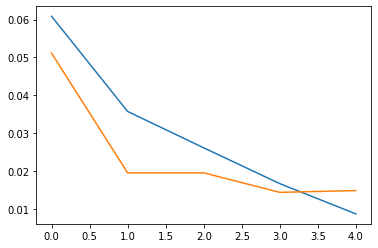

In [29]:
import matplotlib.pyplot as plt
plt.plot(loss_list)
plt.plot(val_loss_list)
plt.show()

In [30]:
model.load_state_dict(torch.load(args.path))
# model_T.load_state_dict(torch.load("bestMaskedEncOversample.pth"))
preds, label, val_loss, _= test(model, validDataloader, args, isGraph=True)
# preds, label, val_loss = test(model, trainDataloader, args)
pred_label = torch.sigmoid(torch.FloatTensor(preds)).numpy()
print(val_loss) # 0.008이 logic값 -> 이진 분류 참 1 거짓 0 0.008 잘된거다

0.008983922357106386


In [31]:
concat = np.hstack((preds, label, pred_label))
result = pd.DataFrame(concat, columns=["pred_val", "label","pred_logit"])
print(result.shape)

(119356, 3)


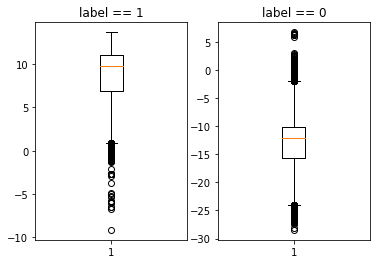

In [32]:
fig, ax = plt.subplots(1,2)
ax[0].boxplot(result.loc[result["label"]==1, "pred_val"].to_numpy())
ax[0].set_title("label == 1")
ax[1].boxplot(result.loc[result["label"]==0, "pred_val"].to_numpy())
ax[1].set_title("label == 0")
plt.show()

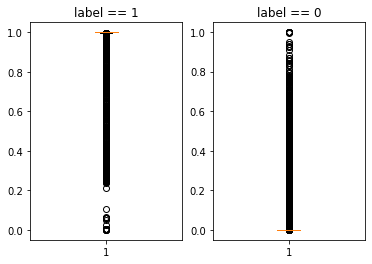

In [33]:
fig, ax = plt.subplots(1,2)
ax[0].boxplot(result.loc[result["label"]==1, "pred_logit"].to_numpy())
ax[0].set_title("label == 1")
ax[1].boxplot(result.loc[result["label"]==0, "pred_logit"].to_numpy())
ax[1].set_title("label == 0")
plt.show()

In [34]:
q_val = result.loc[result["label"]==0, "pred_logit"].quantile(0.999)
print(q_val)
result.loc[result["pred_logit"] > q_val,"pred_label"] = 1
result.loc[result["pred_logit"] <= q_val,"pred_label"] = 0

0.5926765418053004


In [35]:
from sklearn.metrics import classification_report

print(classification_report(result["label"], result["pred_label"]))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    109106
         1.0       0.99      0.96      0.98     10250

    accuracy                           1.00    119356
   macro avg       0.99      0.98      0.99    119356
weighted avg       1.00      1.00      1.00    119356



In [37]:
model.learned_graph.cpu().numpy()

array([[  0,   0,   0, ..., 231, 231, 231],
       [ 47, 149, 114, ...,  15, 109, 209]], dtype=int64)

In [38]:
len(df.columns)

232

In [39]:
dum1 = sorted(list(df.columns))
print(dum1)

['Active connections : (MXBean(com.bea:Name=source01,Type=JDBCConnectionPoolRuntime).ActiveConnectionsCurrentCount)', 'Active connections : (MXBean(com.bea:Name=source01,Type=JDBCDataSourceRuntime).ActiveConnectionsCurrentCount)', 'Active connections : (MXBean(com.bea:Name=source02,Type=JDBCConnectionPoolRuntime).ActiveConnectionsCurrentCount)', 'Active connections : (MXBean(com.bea:Name=source02,Type=JDBCDataSourceRuntime).ActiveConnectionsCurrentCount)', 'Active connections : (MXBean(com.bea:Name=source03,Type=JDBCConnectionPoolRuntime).ActiveConnectionsCurrentCount)', 'Active connections : (MXBean(com.bea:Name=source03,Type=JDBCDataSourceRuntime).ActiveConnectionsCurrentCount)', 'Active connections : (MXBean(com.bea:Name=source04,Type=JDBCConnectionPoolRuntime).ActiveConnectionsCurrentCount)', 'Active connections : (MXBean(com.bea:Name=source04,Type=JDBCDataSourceRuntime).ActiveConnectionsCurrentCount)', 'Active connections : (MXBean(com.bea:Name=source05,Type=JDBCConnectionPoolRunt

In [40]:
columns = [col for col in df.columns if col != "isAnomaly"]+["isAnomaly"]
# print(columns)

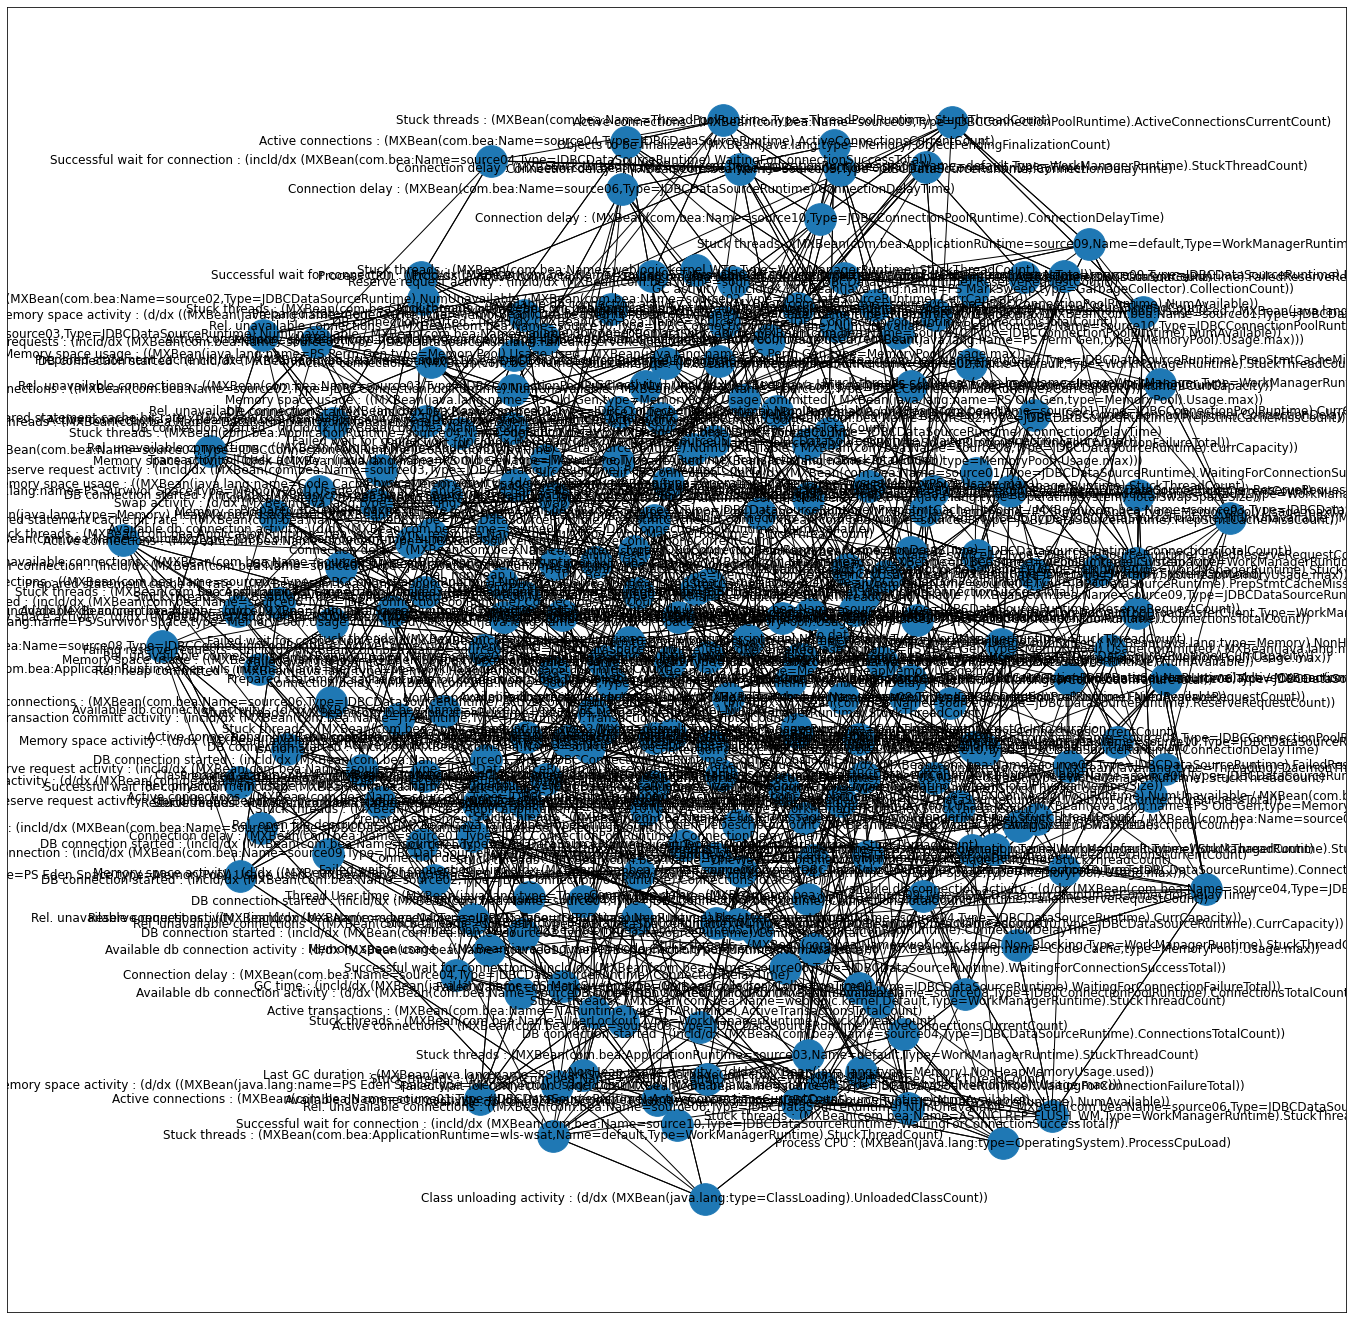

In [41]:
import networkx as nx

graph = model.learned_graph.cpu().numpy()
temp = pd.DataFrame(graph.T,columns=["from", "to"])
change_list = [temp.replace(num, label, inplace=True) for num, label in enumerate(columns)]
graph = list(zip(temp["from"], temp["to"]))

plt.figure(figsize=(24,24))
G = nx.DiGraph()
G.add_edges_from(graph)
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size = 1000)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos)
pass

In [42]:
list(temp.loc[(temp["from"]=="isAnomaly"), "to"])

['Stuck threads : (MXBean(com.bea:Name=JTACoordinatorWM,Type=WorkManagerRuntime).StuckThreadCount)',
 'Successful wait for connection : (incld/dx (MXBean(com.bea:Name=source09,Type=JDBCDataSourceRuntime).WaitingForConnectionSuccessTotal))',
 'Active connections : (MXBean(com.bea:Name=source08,Type=JDBCConnectionPoolRuntime).ActiveConnectionsCurrentCount)',
 'Stuck threads : (MXBean(com.bea:ApplicationRuntime=bea_wls9_async_response,Name=default,Type=WorkManagerRuntime).StuckThreadCount)',
 'Available db connection activity : (d/dx (MXBean(com.bea:Name=source02,Type=JDBCConnectionPoolRuntime).NumAvailable))']

In [45]:
import sklearn
import sklearn.datasets
import sklearn.ensemble
import xgboost
import numpy as np
import lime
import lime.lime_tabular

In [46]:
clf = sklearn.ensemble.RandomForestClassifier(n_estimators=500)
# clf = xgboost.XGBClassifier(n_estimators=500)
clf.fit(trainX, trainy)

RandomForestClassifier(n_estimators=500)

In [47]:
preds = clf.predict(validX)
print(classification_report(validy, preds))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00    109106
        True       1.00      1.00      1.00     10250

    accuracy                           1.00    119356
   macro avg       1.00      1.00      1.00    119356
weighted avg       1.00      1.00      1.00    119356



In [48]:
explainer = lime.lime_tabular.LimeTabularExplainer(trainX, feature_names=df.columns[1:], class_names=df.isAnomaly, discretize_continuous=True)

In [59]:
i = np.random.randint(0, validX.shape[0])
exp = explainer.explain_instance(validX[i], clf.predict_proba, num_features=validX.shape[1], top_labels=5)

In [61]:
print("xgboost")
importances = dict(zip(df.columns, clf.feature_importances_))
importances = {k: v for k, v in sorted(importances.items(), key=lambda item: item[1], reverse=True)}
for idx, key in enumerate(importances.keys()):
    if idx==6:
        break
    print(idx, key)
print("___________")

print("lime")
importances = {col : val for col, val in exp.as_list()}
importances = {k: v for k, v in sorted(importances.items(), key=lambda item: item[1], reverse=True)}
for idx, key in enumerate(importances.keys()):
    if idx==6:
        break
    print(idx, key)
print("___________")

print("gnn")
for idx, col in enumerate(list(temp.loc[(temp["from"]=="isAnomaly"), "to"])):
    print(idx, col)
# sorted(importances, lam)

xgboost
0 Available db connection activity : (d/dx (MXBean(com.bea:Name=source04,Type=JDBCConnectionPoolRuntime).NumAvailable))
1 Stuck threads : (MXBean(com.bea:Name=UserLockout,Type=WorkManagerRuntime).StuckThreadCount)
2 Connection delay : (MXBean(com.bea:Name=source10,Type=JDBCDataSourceRuntime).ConnectionDelayTime)
3 Stuck threads : (MXBean(com.bea:ApplicationRuntime=bea_wls_internal,Name=default,Type=WorkManagerRuntime).StuckThreadCount)
4 Prepared statement cache hit rate : ((MXBean(com.bea:Name=source06,Type=JDBCDataSourceRuntime).PrepStmtCacheHitCount / MXBean(com.bea:Name=source06,Type=JDBCDataSourceRuntime).PrepStmtCacheMissCount))
5 Active connections : (MXBean(com.bea:Name=source08,Type=JDBCConnectionPoolRuntime).ActiveConnectionsCurrentCount)
___________
lime
0 DB connection started : (incld/dx (MXBean(com.bea:Name=source06,Type=JDBCDataSourceRuntime).ConnectionsTotalCount)) <= 0.00
1 Active connections : (MXBean(com.bea:Name=source08,Type=JDBCDataSourceRuntime).ActiveCon

xgboost <br>
0 Available db connection activity : (d/dx (MXBean(com.bea:Name=source04,Type=JDBCConnectionPoolRuntime).NumAvailable))<br>
1 Stuck threads : (MXBean(com.bea:Name=UserLockout,Type=WorkManagerRuntime).StuckThreadCount)<br>
2 Prepared statement cache hit rate : ((MXBean(com.bea:Name=source06,Type=JDBCDataSourceRuntime).PrepStmtCacheHitCount / MXBean(com.bea:Name=source06,Type=JDBCDataSourceRuntime).PrepStmtCacheMissCount))<br>
3 Connection delay : (MXBean(com.bea:Name=source10,Type=JDBCDataSourceRuntime).ConnectionDelayTime)<br>
4 Active connections : (MXBean(com.bea:Name=source08,Type=JDBCConnectionPoolRuntime).ActiveConnectionsCurrentCount)<br>
5 Stuck threads : (MXBean(com.bea:ApplicationRuntime=bea_wls_internal,Name=default,Type=WorkManagerRuntime).StuckThreadCount)<br>
6 Stuck threads : (MXBean(com.bea:Name=weblogic.kernel.System,Type=WorkManagerRuntime).StuckThreadCount)<br>
7 GC activity : (incld/dx (MXBean(java.lang:name=PS Scavenge,type=GarbageCollector).CollectionCount))<br>
8 Failed wait for connection : (incld/dx (MXBean(com.bea:Name=source03,Type=JDBCDataSourceRuntime).WaitingForConnectionFailureTotal))<br>
9 System CPU : (MXBean(java.lang:type=OperatingSystem).SystemCpuLoad)<br>
___________<br>
lime<br>
0 Successful wait for connection : (incld/dx (MXBean(com.bea:Name=source09,Type=JDBCDataSourceRuntime).WaitingForConnectionSuccessTotal)) <= 0.00<br>
1 Rel. unavailable connections : ((MXBean(com.bea:Name=source01,Type=JDBCDataSourceRuntime).NumUnavailable / MXBean(com.bea:Name=source01,Type=JDBCDataSourceRuntime).CurrCapacity)) <= 0.00<br>
2 Rel. unavailable connections : ((MXBean(com.bea:Name=source06,Type=JDBCConnectionPoolRuntime).NumUnavailable / MXBean(com.bea:Name=source06,Type=JDBCConnectionPoolRuntime).CurrCapacity)) <= 0.00<br>
3 Available db connection activity : (d/dx (MXBean(com.bea:Name=source04,Type=JDBCDataSourceRuntime).NumAvailable)) <= 0.33<br>
4 Rel. unavailable connections : ((MXBean(com.bea:Name=source03,Type=JDBCConnectionPoolRuntime).NumUnavailable / MXBean(com.bea:Name=source03,Type=JDBCConnectionPoolRuntime).CurrCapacity)) <= 0.00<br>
5 Memory space usage : ((MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.committed / MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.max)) > 0.99<br>
6 Rel. unavailable connections : ((MXBean(com.bea:Name=source03,Type=JDBCDataSourceRuntime).NumUnavailable / MXBean(com.bea:Name=source03,Type=JDBCDataSourceRuntime).CurrCapacity)) <= 0.00<br>
7 DB connection started : (incld/dx (MXBean(com.bea:Name=source05,Type=JDBCConnectionPoolRuntime).ConnectionsTotalCount)) <= 0.00<br>
8 Connection delay : (MXBean(com.bea:Name=source02,Type=JDBCConnectionPoolRuntime).ConnectionDelayTime) > 0.61<br>
9 Memory space activity : (d/dx ((MXBean(java.lang:name=PS Old Gen,type=MemoryPool).Usage.committed / MXBean(java.lang:name=PS Old Gen,type=MemoryPool).Usage.max))) <= 0.54<br>
___________<br>
gnn<br>
0 Failing reserve requests : (incld/dx (MXBean(com.bea:Name=source08,Type=JDBCDataSourceRuntime).FailedReserveRequestCount))<br>
1 Class loading activity : (d/dx (MXBean(java.lang:type=ClassLoading).LoadedClassCount))<br>
2 Successful wait for connection : (incld/dx (MXBean(com.bea:Name=source10,Type=JDBCDataSourceRuntime).WaitingForConnectionSuccessTotal))<br>
3 DB connection started : (incld/dx (MXBean(com.bea:Name=source10,Type=JDBCConnectionPoolRuntime).ConnectionsTotalCount))<br>
4 System CPU : (MXBean(java.lang:type=OperatingSystem).SystemCpuLoad)<br>
5 Failing reserve requests : (incld/dx (MXBean(com.bea:Name=source02,Type=JDBCDataSourceRuntime).FailedReserveRequestCount))<br>
6 Process CPU : (\Process(java)\CPU)<br>

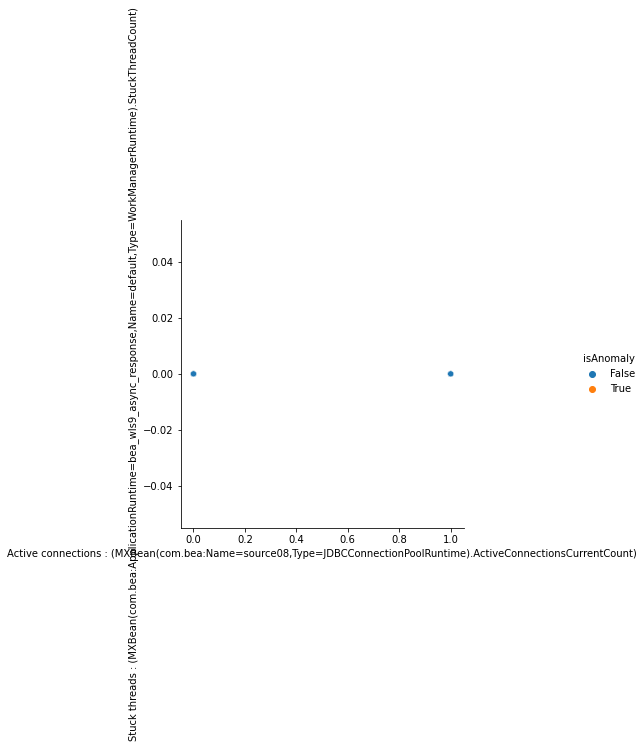

In [52]:
import seaborn as sns

sns.relplot(
    x="Active connections : (MXBean(com.bea:Name=source08,Type=JDBCConnectionPoolRuntime).ActiveConnectionsCurrentCount)", 
    y="Stuck threads : (MXBean(com.bea:ApplicationRuntime=bea_wls9_async_response,Name=default,Type=WorkManagerRuntime).StuckThreadCount)",
    hue="isAnomaly",
    data=df
)

Active connections : (MXBean(com.bea:Name=source08,Type=JDBCConnectionPoolRuntime).ActiveConnectionsCurrentCount)


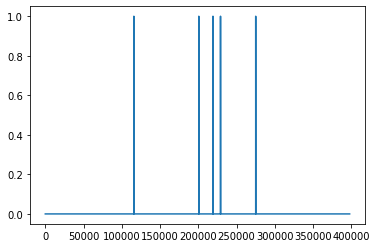

Successful wait for connection : (incld/dx (MXBean(com.bea:Name=source09,Type=JDBCDataSourceRuntime).WaitingForConnectionSuccessTotal))


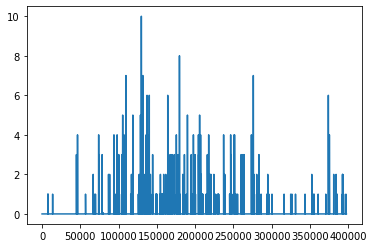

Stuck threads : (MXBean(com.bea:ApplicationRuntime=bea_wls9_async_response,Name=default,Type=WorkManagerRuntime).StuckThreadCount)


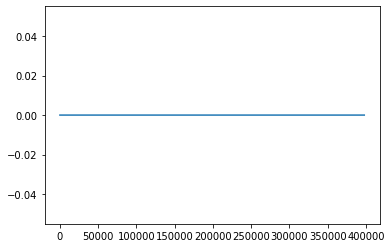

Stuck threads : (MXBean(com.bea:Name=JTACoordinatorWM,Type=WorkManagerRuntime).StuckThreadCount)


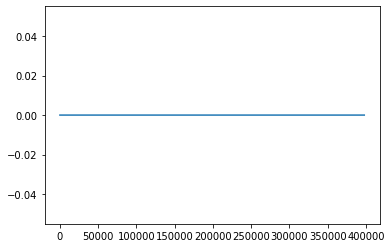

Reserve request activity : (incld/dx (MXBean(com.bea:Name=source01,Type=JDBCDataSourceRuntime).ReserveRequestCount))


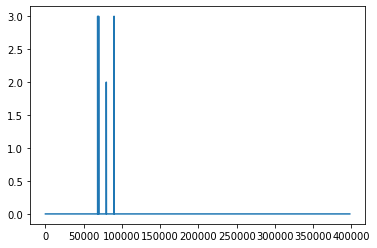

In [53]:
for col in list(temp.loc[(temp["to"]=="isAnomaly"), "from"]):
    print(col)
    plt.plot(df[col])
    plt.show()

lime
Available db connection activity : (d/dx (MXBean(com.bea:Name=source04,Type=JDBCConnectionPoolRuntime).NumAvailable))


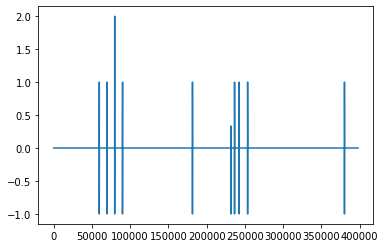

Stuck threads : (MXBean(com.bea:Name=UserLockout,Type=WorkManagerRuntime).StuckThreadCount)


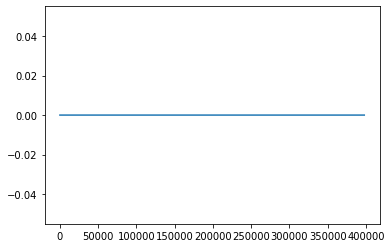

Connection delay : (MXBean(com.bea:Name=source10,Type=JDBCDataSourceRuntime).ConnectionDelayTime)


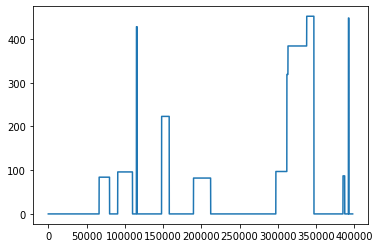

Stuck threads : (MXBean(com.bea:ApplicationRuntime=bea_wls_internal,Name=default,Type=WorkManagerRuntime).StuckThreadCount)


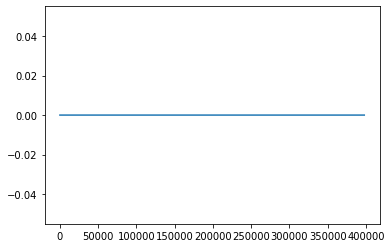

Prepared statement cache hit rate : ((MXBean(com.bea:Name=source06,Type=JDBCDataSourceRuntime).PrepStmtCacheHitCount / MXBean(com.bea:Name=source06,Type=JDBCDataSourceRuntime).PrepStmtCacheMissCount))


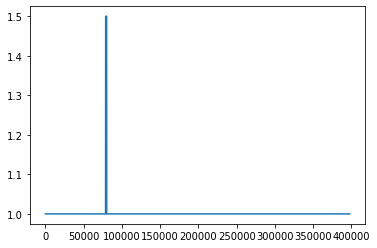

Active connections : (MXBean(com.bea:Name=source08,Type=JDBCConnectionPoolRuntime).ActiveConnectionsCurrentCount)


In [54]:
print("lime")
# importances = {col : val for col, val in exp.as_list()}
importances = dict(zip(df.columns, clf.feature_importances_))
importances = {k: v for k, v in sorted(importances.items(), key=lambda item: item[1], reverse=True)}
for idx, key in enumerate(importances.keys()):
    print(key)
    if idx==5:
        break
    plt.plot(df[key])
    plt.show()

In [ ]:
df = pd.read_csv(csvs[0])
del df["Unnamed: 0"]
del df["host"]
del df["process"]
del df["timestamp"]

In [ ]:
X = df[[col for col in df.columns if col != "isAnomaly"]]
print(X.shape)
y = df["isAnomaly"]

X = scalerX.transform(X)

In [ ]:
testDataset = TorchData(trainX, trainy.to_numpy())

trainDataloader = DataLoader(testDataset, batch_size=96, shuffle=True)